In [1]:
import pickle
import sys
sys.path.append("/home/andy/Desktop/sken_project/fer")
sys.path.append("/home/andy/Desktop/sken_project/fer/src")
sys.path.append("/home/andy/Desktop/sken_project/fer/src/utilities")

In [2]:
from facenet_pytorch import MTCNN
from PIL import Image
import numpy as np
import cv2
from mtcnn.mtcnn import MTCNN as mp

In [3]:
class Frame:
    def __init__(self, frame_id=None, frame_array=None, faces_info=None):
        self.frame_id = frame_id
        self.frame_array = frame_array
        self.faces_info = faces_info

    def get_frame_id(self):
        return self.frame_id

    def set_frame_id(self, value):
        self.frame_id = value

    def get_frame_array(self):
        return self.frame_array

    def set_frame_array(self, value):
        self.frame_array = value

    def get_faces_info(self):
        return self.faces_info

    def set_faces_info(self, value):
        self.faces_info = value
        
    def get_all_face_boxes(self):
        return list(map(lambda x: x.get_bounding_box(),self.get_faces_info()['facial-features']))

    def get_all_face_embeddings(self):
        return list(map(lambda x: x.get_face_encoding(), self.get_faces_info()["facial-features"]))

    def get_all_face_gender(self):
        return list(map(lambda x: x.get_gender(), self.get_faces_info()["facial-features"]))

    def get_all_face_age(self):
        return list(map(lambda x: x.get_age(), self.get_faces_info()["facial-features"]))

    def get_all_face_emotion(self):
        return list(map(lambda x: x.get_emotion(), self.get_faces_info()["facial-features"]))





class Video:
    def __init__(self, video_name, video_path, skipping_frames, total_frames=None, fps=None):
        self.name = video_name
        self.path = video_path
        self.total_frames = total_frames
        self.fps = fps
        self.skipping_frames = skipping_frames
        self.all_frames = []

    def get_name(self):
        return self.name

    def set_name(self, value):
        self.name = value

    def get_path(self):
        return self.path

    def set_path(self, value):
        self.path = value

    def get_total_frames(self):
        return self.total_frames

    def set_total_frames(self, value):
        self.total_frames = value

    def get_fps(self):
        return self.fps

    def set_fps(self, value):
        self.fps = value

    def get_skipping_frames(self):
        return self.skipping_frames

    def set_skipping_frames(self, value):
        self.skipping_frames = value

    def get_all_frame(self):
        return self.all_frames

    def insert_frame(self, value: Frame):
        self.all_frames.append(value)

    def generate_frames(self):
        logger.info("Generating frames for video_file={} at path={}".format(self.name, self.path))
        file_path = os.path.join(self.path, self.name)
        assert os.path.exists(file_path), 'File {} could not be found'.format(file_path)
        cap = cv2.VideoCapture(file_path)
        self.set_total_frames(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.set_fps(cap.get(cv2.CAP_PROP_FPS))
        frame_number = 1
        while True:
            ret, frame = cap.read()
            if ret:
                if frame_number % self.get_skipping_frames() == 0:
                    frame_obj = Frame(frame_id=frame_number,
                                                  frame_array=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                    print(frame_obj.frame_id)
                    yield frame_obj
            else:
                break
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            frame_number += 1
            print("DOne frame = {}/{}".format(frame_number, self.get_total_frames()))
        logger.info("Releasing the video file = {}".format(file_path))
        cap.release()

    def draw_output(self):
        logger.info("Starting Drawing the file {}".format(os.path.join(self.path, self.name)))
        print(len(self.all_frames))
        for i in range(2, len(self.all_frames)):
            f1, f2, f3 = self.all_frames[i], self.all_frames[i - 1], self.all_frames[i - 2]
            if f1.get_faces_info()['face_counts'] is None:
                continue
            f1_face_embeddings, f2_face_embeddings, f3_face_embeddings = f1.get_all_face_embeddings(), f2.get_all_face_embeddings(), f3.get_all_face_embeddings()
            cos_sim12, cos_sim23 = cosine_similarity(f1_face_embeddings, f2_face_embeddings), cosine_similarity(
                f2_face_embeddings, f3_face_embeddings)
            emotion = []
            age = []
            gender = []
            for j, row in enumerate(np.argmax(cos_sim12, axis=1)):
                if cos_sim12[j][row] >= 0.9:
                    delta_emotion, delta_age, delta_gender = [f1.get_all_face_emotion()[j],
                                                              f2.get_all_face_emotion()[row]], [
                                                                 f1.get_all_face_age()[j],
                                                                 f2.get_all_face_age()[row]], [
                                                                 f1.get_all_face_gender()[j],
                                                                 f2.get_all_face_gender()[row]]
                    max_2 = np.argmax(cos_sim23[row])
                    if cos_sim23[row][max_2] > 0.9:
                        delta_emotion.append(f3.get_all_face_emotion()[max_2])
                        delta_age.append(f3.get_all_face_age()[max_2])
                        delta_gender.append(f3.get_all_face_gender()[max_2])
                    emotion.append(delta_emotion)
                    age.append(delta_age)
                    gender.append(delta_gender)
            frame = f1.get_frame_array()
            print(frame.shape)
            for (x, y, w, h), gen, umar, emo in zip(f1.get_all_face_boxes(), gender, age, emotion):
                cv2.rectangle(frame, (int(x), int(y)), (int(x) + int(w), int(y) + int(h)), (0, 0, 255), 2)
                cv2.putText(frame, f'emotion:{mp(emo).mode[0]}|age:{mp(umar).mode[0]}|sex:{mp(gen).mode[0]}',
                            (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX,
                            0.5,
                            (0, 0, 255), 2)
            cv2.imshow('output', frame)
            cv2.waitKey(10000)


In [4]:
with open("/tmp/video.pkl",'rb') as fp:
    video = pickle.load(fp)

In [5]:
video.get_all_frame()[221].get_frame_array()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [48]:
model2= MTCNN(margin=40, select_largest=False, post_process=False,)

In [49]:
import imutils

In [7]:
img1 = video.get_all_frame()[0].get_frame_array()
img2 = cv2.resize(img1,(800,800))

In [11]:
img2.shape

(800, 800, 3)

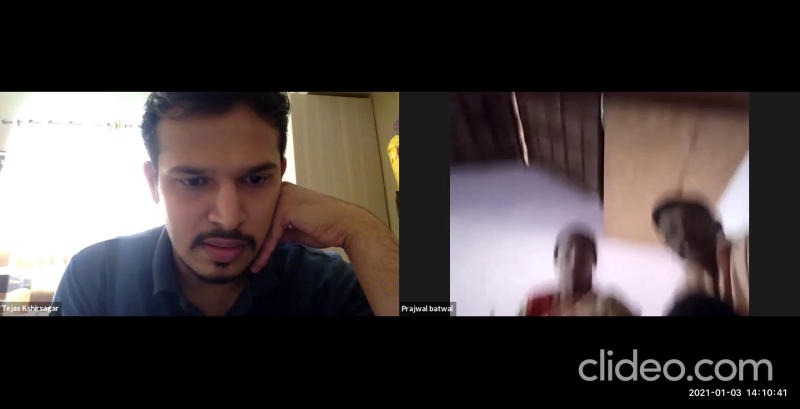

In [14]:
Image.fromarray(img1)

In [50]:
img_arr = imutils.resize(video.get_all_frame()[221].get_frame_array(),width=800)
faces = model2.detect(img_arr)

In [51]:
face_arrays = []
for x,y,x_,y_ in faces[0]:
    face_arrays.append(img_arr[int(y):int(abs(y_)),int(x):int(abs(x_)),:])

In [52]:
import time
all_faces = []
for face in face_arrays:
    all_faces.append(Image.fromarray(face))
    time.sleep(1)

In [61]:
np.asarray(all_faces[2]).shape

(112, 76, 3)

In [67]:
cv2.resize(np.asarray(all_faces[2]), (224, 224)).shape

(224, 224, 3)